<a href="https://colab.research.google.com/github/rajuvarla/pgcp_project1_group4_image_captioning/blob/main/v7_Keras_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
token_path = "/content/drive/MyDrive/AMIL_PGCP/Flickr8k_text/Flickr8k.token.txt"
train_images_path = '/content/drive/MyDrive/AMIL_PGCP/Flickr8k_text/Flickr_8k.trainImages.txt'
test_images_path = '/content/drive/MyDrive/AMIL_PGCP/Flickr8k_text/Flickr_8k.testImages.txt'
images_path = '/content/drive/MyDrive/AMIL_PGCP/Flickr8k_Dataset/Flicker8k_Dataset/'
glove_path = '/content/drive/MyDrive/AMIL_PGCP'

doc = open(token_path,'r').read()
print(doc[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [ ]:
descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
          image_id = tokens[0].split('.')[0]
          image_desc = ' '.join(tokens[1:])
          if image_id not in descriptions:
              descriptions[image_id] = list()
          descriptions[image_id].append(image_desc)

In [ ]:
descriptions

{'1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'There is a gi

In [ ]:
table = str.maketrans('', '', string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

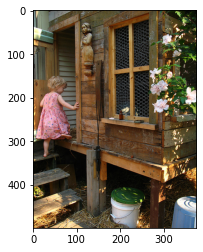

['a child in a pink dress is climbing up a set of stairs in an entry way ',
 'a girl going into a wooden building ',
 'a little girl climbing into a wooden playhouse ',
 'a little girl climbing the stairs to her playhouse ',
 'a little girl in a pink dress going into a wooden cabin ']

In [ ]:
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

In [ ]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8828


In [ ]:
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [ ]:
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)

train = set(dataset)

In [ ]:
img = glob.glob(images_path + '*.jpg')
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)

In [ ]:
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        train_descriptions[image_id].append(desc)

In [ ]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

In [ ]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1659


In [ ]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1

In [ ]:
all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 38


In [ ]:
embeddings_index = {} 
f = open(os.path.join(glove_path, 'glove.6B.200d.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [ ]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
model = InceptionV3(weights='imagenet')

96124928/96112376 [==============================] - 1s 0us/step


In [ ]:
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images_path):]] = encode(img)

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 200)      332000      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
epochs = 50
batch_size = 3
steps = len(train_descriptions)//batch_size

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/50
2000/2000 [==============================] - 492s 244ms/step - loss: 3.6862 - accuracy: 0.3070
Epoch 2/50
2000/2000 [==============================] - 474s 237ms/step - loss: 3.0285 - accuracy: 0.3620
Epoch 3/50
2000/2000 [==============================] - 457s 229ms/step - loss: 2.8322 - accuracy: 0.3801
Epoch 4/50
2000/2000 [==============================] - 445s 223ms/step - loss: 2.7133 - accuracy: 0.3917
Epoch 5/50
2000/2000 [==============================] - 445s 222ms/step - loss: 2.6291 - accuracy: 0.3996
Epoch 6/50
2000/2000 [==============================] - 452s 226ms/step - loss: 2.5636 - accuracy: 0.4067
Epoch 7/50
2000/2000 [==============================] - 455s 228ms/step - loss: 2.5147 - accuracy: 0.4104
Epoch 8/50
2000/2000 [==============================] - 448s 224ms/step - loss: 2.4708 - accuracy: 0.4156
Epoch 9/50
2000/2000 [==============================] - 449s 225ms/step - loss: 2.4360 - accuracy: 0.4189
Epoch 10/50
2000/2000 [=======================

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
captions = open('../content/drive/MyDrive/AMIL_PGCP/Flickr8k_text/Flickr8k.token.txt', 'rb').read().decode('utf-8').split('\n')
def getrealcaptions(x):
  realcaptions = []
  realcaptions1 = []
  for i in captions:
    try:
        img_name = i.split('\t')[0][:-2]
        caption = i.split('\t')[1]
        if(x == img_name):
          subcap = caption.lower().split() 
          realcaptions.append(subcap)
          realcaptions1.append(caption)
    except:
      pass
  return realcaptions,realcaptions1

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
def getrealcaptions1(x):
  realcaptions = []
  for i in descriptions[x.split('.')[0]]:
    subcap = i.split()
    realcaptions.append(subcap)
   
  return descriptions[x.split('.')[0]],realcaptions

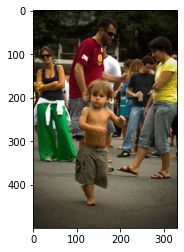

reference: [['a', 'boy', 'without', 'a', 'shirt', 'is', 'running', 'in', 'the', 'street', 'while', 'several', 'people', 'stand', 'behind', 'him'], ['a', 'little', 'boy', 'dances', 'with', 'a', 'group', 'of', 'people', 'behind', 'him', 'on', 'a', 'city', 'street'], ['a', 'small', 'boy', 'dances', 'on', 'the', 'concrete', 'surrounded', 'by', 'adults'], ['the', 'little', 'boy', 'wearing', 'no', 'shirt', 'is', 'running', 'by', 'a', 'crowd', 'of', 'people'], ['the', 'shirtless', 'little', 'boy', 'is', 'walking', 'around', 'adults']]
Greedy Search: a group of children play on a sculpture
BLEU for Greedy Search: 0.45966135761245924
Beam Search, K = 3: a group of children playing on a sprinkler
BLEU for beamsearch3: 0.45966135761245924
Beam Search, K = 5: a group of children are playing soccer in a field
BLEU for beamsearch5: 0.34329452398451965
Beam Search, K = 7: a group of children play in a pile of toilet paper
BLEU for beamsearch7: 0.31702331385234306
Beam Search, K = 10: a group of child

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
pic = '2064790732_219e52e19c.jpg'
#image = encoding_train[pic].reshape((1,2048))
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
reference = getrealcaptions1(pic)
print("reference:",reference)
greedysearch1 = greedySearch(image)
beamsearch3 = beam_search_predictions(image, beam_index = 3)
beamsearch5 = beam_search_predictions(image, beam_index = 5)
beamsearch7 = beam_search_predictions(image, beam_index = 7)
beamsearch10 = beam_search_predictions(image, beam_index = 10)
print("Greedy Search:",greedysearch1)
print("BLEU for Greedy Search:",sentence_bleu(reference, greedysearch1.split()))
print("Beam Search, K = 3:",beamsearch3)
print("BLEU for beamsearch3:",sentence_bleu(reference, beamsearch3.split()))
print("Beam Search, K = 5:",beamsearch5)
print("BLEU for beamsearch5:",sentence_bleu(reference, beamsearch5.split()))
print("Beam Search, K = 7:",beamsearch7)
print("BLEU for beamsearch7:",sentence_bleu(reference, beamsearch7.split()))
print("Beam Search, K = 10:",beamsearch10)

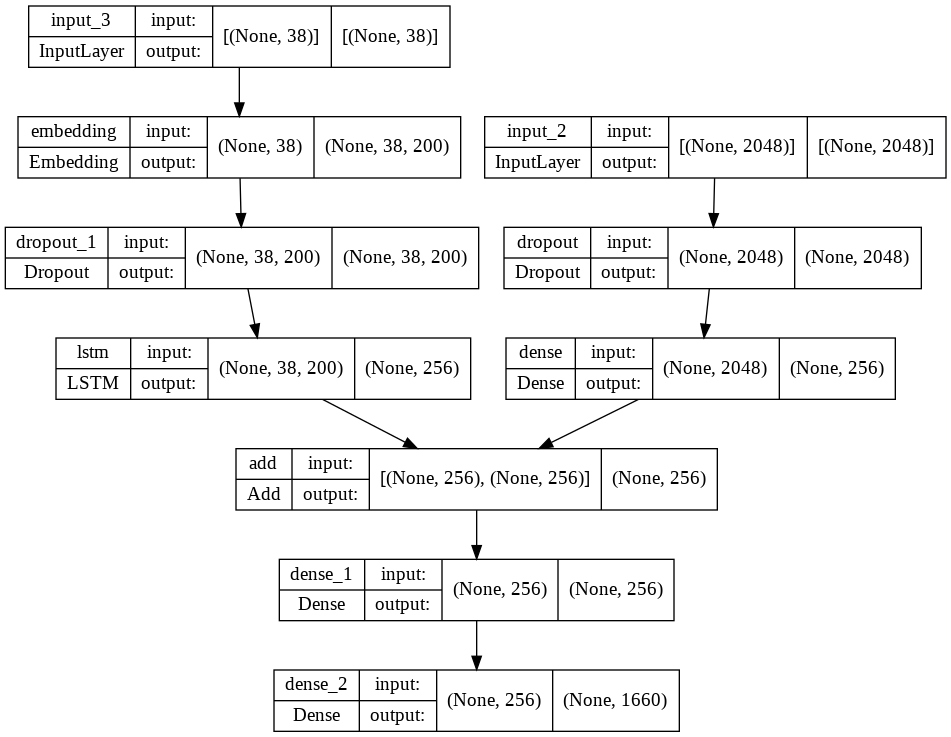

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='../content/drive/MyDrive/AMIL_PGCP/v7_model.png', show_shapes=True)

In [ ]:
descriptions['36422830_55c844bc2d']

['a four wheel drive car is navigating along a rocky off road trail ',
 'a jeep sidewalks on some rocks ',
 'a red jeep hangs from the edge of a rocky cliff as a girl looks on ',
 'a red truck is driving over a rocky surface ',
 'a woman stands next to a red suv that has run off into a ditch ']

In [ ]:
model.save('../content/drive/MyDrive/AMIL_PGCP/v7_model.h5')

In [ ]:
model.save_weights('../content/drive/MyDrive/AMIL_PGCP/v7_model_weights.h5')

In [ ]:
np.save('../content/drive/MyDrive/AMIL_PGCP/v7_vocab.npy', ixtoword)

In [ ]:
model_new.save('../content/drive/MyDrive/AMIL_PGCP/v7_inceptionmodel.h5')

In [ ]:
test_img[0]

'/content/drive/MyDrive/AMIL_PGCP/Flickr8k_Dataset/Flicker8k_Dataset/106490881_5a2dd9b7bd.jpg'

In [ ]:
import pandas as pd
column_names = ["filename","realcaptions", "greedysearch", "beamsearch3","beamsearch5","beamsearch7","beamsearch10","greedysearchscore", "beamsearch3score","beamsearch5score","beamsearch7score","beamsearch10score"]
df = pd.DataFrame(columns = column_names)

In [ ]:
df

,filename,realcaptions,greedysearch,beamsearch3,beamsearch5,beamsearch7,beamsearch10,greedysearchscore,beamsearch3score,beamsearch5score,beamsearch7score,beamsearch10score


In [ ]:
for i in test_img:
  pic = i.split('/')[-1]
  print("img:",pic)
  image = encoding_test[pic].reshape((1,2048))
  realcpations,reference = getrealcaptions1(pic)
  #print("reference:",reference)
  greedysearch1 = greedySearch(image)
  beamsearch3 = beam_search_predictions(image, beam_index = 3)
  beamsearch5 = beam_search_predictions(image, beam_index = 5)
  beamsearch7 = beam_search_predictions(image, beam_index = 7)
  beamsearch10 = beam_search_predictions(image, beam_index = 10)
  greedysearchscore = sentence_bleu(reference, greedysearch1.split())
  beamsearch3score = sentence_bleu(reference, beamsearch3.split())
  beamsearch5score = sentence_bleu(reference, beamsearch5.split())
  beamsearch7score = sentence_bleu(reference, beamsearch7.split())
  beamsearch10score = sentence_bleu(reference, beamsearch10.split())
  new_row = {'filename':pic,'realcaptions':realcpations, 'greedysearch':greedysearch1, 'beamsearch3':beamsearch3,'beamsearch5':beamsearch5,'beamsearch7':beamsearch7,'beamsearch10':beamsearch10,'greedysearchscore':greedysearchscore, 'beamsearch3score':beamsearch3score,'beamsearch5score':beamsearch5score,'beamsearch7score':beamsearch7score,'beamsearch10score':beamsearch10score}
  df = df.append(new_row, ignore_index=True)


img: 106490881_5a2dd9b7bd.jpg


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


img: 2774430374_fee1d793e7.jpg
img: 3530843182_35af2c821c.jpg
img: 3485425825_c2f3446e73.jpg


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


img: 311146855_0b65fdb169.jpg
img: 2894217628_f1a4153dca.jpg
img: 96420612_feb18fc6c6.jpg
img: 3692593096_fbaea67476.jpg
img: 2105756457_a100d8434e.jpg
img: 3399284917_721aefe2a7.jpg
img: 3424424006_98f9d1921c.jpg
img: 3429956016_3c7e3096c2.jpg
img: 2288099178_41091aa00c.jpg
img: 3258874419_23fec1bdc1.jpg
img: 3427118504_93126c83e0.jpg
img: 3025549604_38b86198f5.jpg
img: 2396691909_6b8c2f7c44.jpg
img: 2926595608_69b22be8d4.jpg
img: 3108732084_565b423162.jpg
img: 370713359_7560808550.jpg
img: 2526041608_a9775ab8d7.jpg
img: 3398746625_5199beea71.jpg
img: 2991994607_06f24ec7a6.jpg
img: 3416091866_a96003d652.jpg
img: 3048597471_5697538daf.jpg
img: 473220329_819a913bbb.jpg
img: 2445283938_ff477c7952.jpg
img: 3227148358_f152303584.jpg
img: 2197275664_fabcf3424b.jpg
img: 3741462565_cc35966b7a.jpg
img: 3053743109_a2d780c0d2.jpg
img: 2677656448_6b7e7702af.jpg
img: 241345905_5826a72da1.jpg
img: 3482062809_3b694322c4.jpg
img: 3115174046_9e96b9ce47.jpg
img: 1433142189_cda8652603.jpg
img: 301586318

In [ ]:
df.to_csv("../content/drive/MyDrive/AMIL_PGCP/v7_test_results.csv")